# DBSCAN clustering to reduce spatial data set size

This notebook reduces the size of a spatial data set by clustering with DBSCAN. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

You might also be interested in [this notebook](https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb) that uses this technique to cluster 1.2 million spatial data points and [this write-up](http://geoffboeing.com/2016/06/mapping-everywhere-ever-been/) of that project.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from time import time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [2]:
# load the data set
df = pd.read_csv('data/summer-travel-gps-full.csv')
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


In [3]:
# Compute DBSCAN
# eps is the physical distance from each point that forms its neighborhood
# min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise
start_time = time()
coordinates = df.as_matrix(columns=['lon', 'lat'])
db = DBSCAN(eps=.01, min_samples=1, algorithm='ball_tree', metric='haversine').fit(coordinates)
cluster_labels = db.labels_

# number of clusters in labels, ignoring noise if present
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} points, for {:0.1f}% compression in {:0.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coordinates, cluster_labels)))

Clustered 1,759 points down to 147 points, for 91.6% compression in 0.10 seconds
Silhouette coefficient: 0.833


In [4]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])

In [5]:
# find the point in each cluster that is closest to its centroid
# DBSCAN clusters may be non-convex: this just returns one representative point from each cluster
def get_centermost_point(cluster):
    centroid = MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return centermost_point

centermost_points = clusters.map(get_centermost_point)

In [6]:
# use list comprehension to extract the lat and lon out of the centermost points tuples
longitudes = [point[0] for point in centermost_points]
latitudes = [point[1] for point in centermost_points]

# from these lats and lons create a new dataframe of one representative point for each cluster
rep_points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})
rep_points.tail()

,lat,lon
142,37.933913,23.945805
143,40.980462,28.820527
144,41.033193,28.982041
145,41.014963,29.010762
146,48.356285,11.791710


In [7]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.tail()

,lat,lon,date,city,country
142,37.933913,23.945805,07/06/2014 17:27,Attica,Greece
143,40.980462,28.820527,07/06/2014 21:27,Istanbul,Turkey
144,41.033193,28.982041,07/08/2014 15:30,Istanbul,Turkey
145,41.014963,29.010762,07/07/2014 16:56,Istanbul,Turkey
146,48.356285,11.791710,07/09/2014 13:17,Munich,Germany


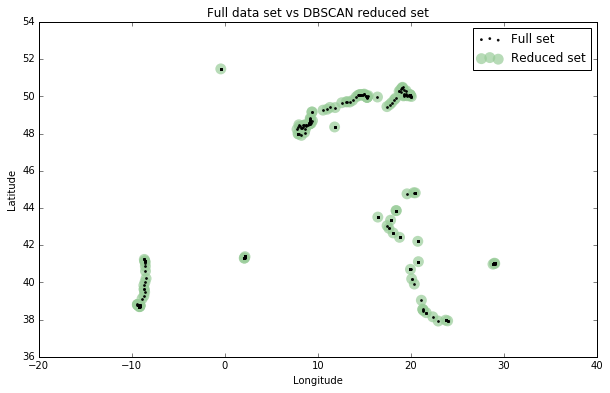

In [8]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()